In [ ]:
# Yapılan paylaşımların  pozitif veya negatif olarak sınıflandırılması işlemi

In [33]:

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from snowballstemmer import TurkishStemmer
import nltk
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,confusion_matrix
from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from warnings import filterwarnings
filterwarnings('ignore')

Metin ön işleme işlemleri.

In [25]:
df = pd.read_csv("twitter_veri.csv",delimiter=",",encoding="windows-1254")
df.head()

,Tip,Paylaşım
0,Negatif,doğa ağzımıza sıçsa hakkı var
1,Pozitif,anne bir sanatçıdır güzel eseri yavrusudur
2,Negatif,ibrahimin oğlunu koruyan tanrı ben sokayım
3,Negatif,köpeğim suratına sıçsın senin namussuz karı
4,Negatif,ben söğüşledim birazda sen söğüşle


In [26]:
# eksik veri kontrolü

print(df.isnull().sum())
print()
print(df.info())
df.shape

Tip         0
Paylaşım    2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tip       11119 non-null  object
 1   Paylaşım  11117 non-null  object
dtypes: object(2)
memory usage: 173.9+ KB
None


(11119, 2)

In [27]:
df = df.dropna()
df.isnull().sum()

Tip         0
Paylaşım    0
dtype: int64

In [28]:
# •	Büyük küçük harf dönüşümü
# •	Noktalama işaretlerin çıkarılması
# •	Numerik ifadelerin çıkarılması

def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    # Punctuations
    text = text.str.replace(r'[^\w\s]', '')
    text = text.str.replace("\n" , '')
    # Numbers
    text = text.str.replace('\d', '')
    return text

df["Paylaşım"] = clean_text(df["Paylaşım"])

df.head()

,Tip,Paylaşım
0,Negatif,doğa ağzımıza sıçsa hakkı var
1,Pozitif,anne bir sanatçıdır güzel eseri yavrusudur
2,Negatif,ibrahimin oğlunu koruyan tanrı ben sokayım
3,Negatif,köpeğim suratına sıçsın senin namussuz karı
4,Negatif,ben söğüşledim birazda sen söğüşle


In [29]:
# Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimelerin çıkarılması

def remove_stopwords(text):
    stop_words = stopwords.words('turkish')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

df["Paylaşım"] = remove_stopwords(df["Paylaşım"])
df

,Tip,Paylaşım
0,Negatif,doğa ağzımıza sıçsa hakkı var
1,Pozitif,anne bir sanatçıdır güzel eseri yavrusudur
2,Negatif,ibrahimin oğlunu koruyan tanrı ben sokayım
3,Negatif,köpeğim suratına sıçsın senin namussuz karı
4,Negatif,ben söğüşledim birazda sen söğüşle
...,...,...
11114,Pozitif,bugün hava güzel
11115,Pozitif,allah akıl fikir versin
11116,Negatif,allah belanı versin
11117,Pozitif,allah akıl fikir versin sana


In [30]:
# Metinde az tekrarlayan kelimeleri bulunuz.

pd.Series(' '.join(df['Paylaşım']).split()).value_counts()[-1000:]

karışmıyor         1
akfc               1
soğuyacağım        1
anılı              1
olmustur           1
                  ..
olmazmi            1
bogucaktı          1
kızkardeşini       1
dengesi            1
karaktersizleri    1
Name: count, Length: 1000, dtype: int64

In [31]:
# Metinde az tekrarlayan kelimeleri metin içerisinden çıkartınız.

sil = pd.Series(' '.join(df['Paylaşım']).split()).value_counts()[-1000:]

df['Paylaşım'] = df['Paylaşım'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [32]:
# Metinleri tokenize edip sonuçları gözlemleyiniz.

df["Paylaşım"].apply(lambda x: TextBlob(x).words)

0                                [doğa, sıçsa, hakkı, var]
1        [anne, bir, sanatçıdır, güzel, eseri, yavrusudur]
2        [ibrahimin, oğlunu, koruyan, tanrı, ben, sokayım]
3        [köpeğim, suratına, sıçsın, senin, namussuz, k...
4                 [ben, söğüşledim, birazda, sen, söğüşle]
                               ...                        
11114                                 [bugün, hava, güzel]
11115                         [allah, akıl, fikir, versin]
11116                              [allah, belanı, versin]
11117                   [allah, akıl, fikir, versin, sana]
11118                         [allah, akıl, fikir, versin]
Name: Paylaşım, Length: 11117, dtype: object

In [34]:
# TurkishStemmer nesnesini oluştur
snowBallStemmer = TurkishStemmer()

# Kelime köklerini bulan fonksiyon
def kelime_kök_alma(metin):
    wordlist = nltk.word_tokenize(metin)
    stemWords = [snowBallStemmer.stemWord(kelime) for kelime in wordlist]
    return " ".join(stemWords)

df['Paylaşım'] = df['Paylaşım'].apply(kelime_kök_alma)

df.head()

,Tip,Paylaşım
0,Negatif,dok sıç hakkı var
1,Pozitif,anne bir sanatçı güzel eser yavrus
2,Negatif,ibrah oğl koruya tanrı ben sok
3,Negatif,köpek surat sıç se namussuz kar
4,Negatif,ben söğüşledi biraz sen söğüş


In [35]:
# Metindeki terimlerin frekanslarını hesaplayınız. (Barplot grafiği için gerekli)

tf = df["Paylaşım"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.head()


,index,0
0,dok,63.00
1,sıç,19.00
2,hakkı,22.00
3,var,774.00
4,anne,64.00


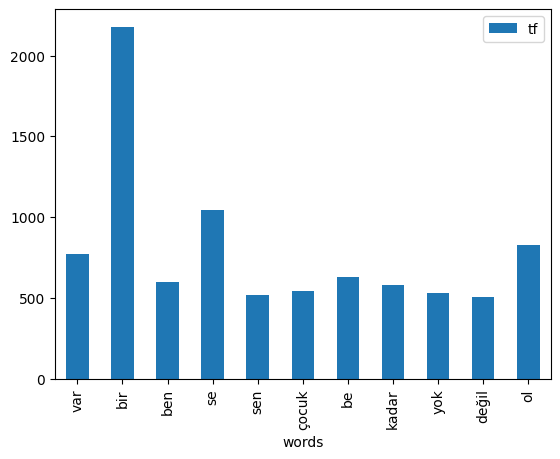

In [36]:
# Barplot grafiğini oluşturunuz.

# Sütunların isimlendirilmesi
tf.columns = ["words", "tf"]

# 500'den fazla geçen kelimelerin görselleştirilmesi
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

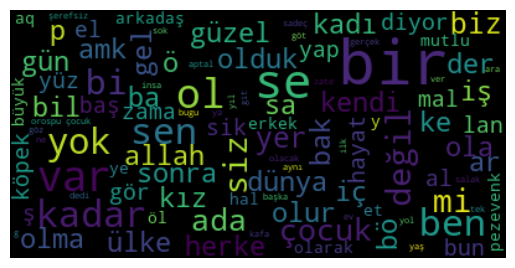

In [37]:
# Kelimeleri WordCloud ile görselleştiriniz.

# kelimeleri birleştirdik
text = " ".join(i for i in df["Paylaşım"])

# wordcloud görselleştirmenin özelliklerini belirliyoruz
wordcloud = WordCloud(max_font_size=50,
max_words=100,
background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
df.head()

,Tip,Paylaşım
0,Negatif,dok sıç hakkı var
1,Pozitif,anne bir sanatçı güzel eser yavrus
2,Negatif,ibrah oğl koruya tanrı ben sok
3,Negatif,köpek surat sıç se namussuz kar
4,Negatif,ben söğüşledi biraz sen söğüş


In [39]:
# veri seti içerisinde bulunan "Negatif" değerleri 0 "Pozitif" değerleri ise 1 yapıyoruz.

df["sınıf"] = [0 if (i=="Negatif") else 1 for i in df["Tip"]]

df.head()

,Tip,Paylaşım,sınıf
0,Negatif,dok sıç hakkı var,0
1,Pozitif,anne bir sanatçı güzel eser yavrus,1
2,Negatif,ibrah oğl koruya tanrı ben sok,0
3,Negatif,köpek surat sıç se namussuz kar,0
4,Negatif,ben söğüşledi biraz sen söğüş,0


Makine öğrenmesine hazırlık!

In [40]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olara ayırınız.

x_train, x_test, y_train, y_test = train_test_split(df["Paylaşım"],df["sınıf"],random_state=42,stratify=df["sınıf"])

In [41]:
# Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte.
# TfidfVectorizer kullannarak

tf_idf_word_vectorizer = TfidfVectorizer().fit(x_train)
x_train = tf_idf_word_vectorizer.transform(x_train)
x_test = tf_idf_word_vectorizer.transform(x_test)


In [44]:
# modeli kurarak train dataları ile fit ediniz.

model = MultinomialNB()
model_fit = model.fit(x_train, y_train)

# Test verilerini kullanarak tahmin yapın
y_pred = model_fit.predict(x_test)

score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("accuracy: ",score,"\n")
print("confusion_matrix:","\n",cm)


accuracy:  0.8564748201438849 

confusion_matrix: 
 [[ 957  294]
 [ 105 1424]]


In [45]:
# Çapraz doğrulama skorunu hesaplayın ve yazdırın
cross_val_mean = cross_val_score(model, x_test, y_test, cv=5, n_jobs=-1).mean()
print("Cross-Validation Score:", cross_val_mean)

Cross-Validation Score: 0.8179856115107913
